In [1]:
from numba import njit
from numba import types
from numba.typed import Dict
from numba import njit
from numba import njit, prange, jit
from qutip import *

from matplotlib import pyplot as plt

In [2]:
import string
import random

def get_random_string(length, name = 'custom_text'):
    # With combination of lower and upper case
    result_str = 'plots/'
    if (name != 'custom_text'):
        result_str += str(name) + '_'
    result_str += ''.join(random.choice(string.ascii_letters) for i in range(length))
    result_str += '.pdf'
    return(result_str)

In [3]:
import numpy as np
from math import exp, sqrt, ceil, log, floor
from functools import cached_property
from numba import jit

class Matrix:
    def __init__(self, nmin: int, nmax: int):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['defects'] = {}

        self.matrix = self.gen_matrix_empty()

    @property # nmin should be read only
    def nmin(self):
        return self.__dict__['nmin']

    @property # nmax should be read only
    def nmax(self):
        return self.__dict__['nmax']

    @property # defects should be read only
    def defects(self):
        return self.__dict__['defects']

    @cached_property # array flattened to 2d
    def data(self):
        return self.make_array()

    def gen_matrix_empty(self):
        """
        Generate zero matrix of mm[n][l][n'][l']
        output is a nested dictionary
        """
        nn = np.arange(self.nmin, self.nmax+1, 1)
        mm = {}
        for a in nn:
            l1 = np.arange(0,a)
            m1 = {}
            for b in l1:
                m2 = {}
                for c in nn:
                    l2 = np.arange(0,c)
                    m3 = {}
                    for d in l2:
                        m3[d] = 0
                    m2[c] = m3
                m1[b] = m2
            mm[a] = m1
        return mm

    def make_array(self):
        mm = self.matrix

        size = sum(np.arange(min(mm.keys()), max(mm.keys())+1, 1))

        m = np.empty((size,size))
        i = 0
        j = 0

        for a in mm.keys():
            for b in mm[a].keys():
                for c in mm[a][b].keys():
                    for d in mm[a][b][c].keys():
                        m[i][j] = mm[a][b][c][d]
                        j += 1
                j = 0
                i += 1
        return m
    
    def eigen(self):
        return np.linalg.eigh(self.data)[0]

    def _get_qd(self, n, l):
        qd = self.defects
        if l in qd:
            if type(qd[l]) == list:
                defect = 0
                m = n - qd[l][0]
                for i in range(len(qd[l])):
                    defect = defect + qd[l][i]*m**(-2*i)
                return defect
            else:
                return qd[l]
        else:
            return float(0)

    def __repr__(self):
        return str(self.matrix)

    def __mul__(self, scaler: float):

        mm = self.matrix
        matrixProduct = Matrix(self.nmin, self.nmax)
        for a in mm.keys():
            for b in mm[a].keys():
                for c in mm[a][b].keys():
                    for d  in mm[a][b][c].keys():
                        matrixProduct.matrix[a][b][c][d] = mm[a][b][c][d] * scaler
        return matrixProduct

    def __add__(self, other):
        mm = self.matrix
        matrixSum = Matrix(self.nmin, self.nmax)

        for a in mm.keys():
            for b in mm[a].keys():
                for c in mm[a][b].keys():
                    for d  in mm[a][b][c].keys():
                        matrixSum.matrix[a][b][c][d] = mm[a][b][c][d] + other.matrix[a][b][c][d]
        return matrixSum

    def __sub__(self, other):
        mm = self.matrix
        matrixSum = Matrix(self.nmin, self.nmax)

        for a in mm.keys():
            for b in mm[a].keys():
                for c in mm[a][b].keys():
                    for d  in mm[a][b][c].keys():
                        matrixSum.matrix[a][b][c][d] = mm[a][b][c][d] - other.matrix[a][b][c][d]
        return matrixSum
    
    def __getitem__(self, a):
        return self.matrix[a]

class MatrixH0(Matrix):
    def __init__(self, nmin: int, nmax: int, defects = {}):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['defects'] = defects

        # Make H0 array
        mm = self.gen_matrix_empty()
        for i in mm.keys():
            for j in mm[i].keys():
                mm[i][j][i][j] = -0.5 * (i - self._get_qd(i,j))**(-2)
        self.matrix = mm

class MatrixHs(Matrix):
    def __init__(self, nmin: int, nmax: int, defects = {}):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['defects'] = defects

        # Make HS array
        m = 0
        mm = self.gen_matrix_empty()
        elems = []
        for i in range(self.nmax-1):
            elem = (i, i+1)
            elems.append(elem)

        for elem in elems:
            l1 = elem[0]
            l2 = elem[1]

            for i in mm.keys(): # n1
                if l1 < i:
                    ns1 = i - self._get_qd(i, l1)
                    wf1 = Tools.numerov(ns1, l1, self.nmax)

                    for j in mm[i][l1].keys():
                        if l2 < j:
                            ns2 = j - self._get_qd(j, l2)
                            wf2 = Tools.numerov(ns2, l2, self.nmax)
                            radialInt = Tools.numerov_calc_matrix_element(wf1, wf2)

                            try:
                                test = mm[i][l1][j][l2] # Check for entry
                                angularElem = ((l1 + 1)**2 - m**2)/((2*l1+3)*(2*l1+1))
                                angularElem = sqrt(angularElem)
                                mm[i][l1][j][l2] = radialInt * angularElem
                            except KeyError:
                                pass

                            try:
                                test = mm[j][l2][i][l1]

                                angularElem = (l2**2 - m**2)/((2*l2+1)*(2*l2-1))
                                angularElem = sqrt(angularElem)
                                mm[j][l2][i][l1] = radialInt * angularElem
                            except KeyError:
                                pass
        self.matrix = mm

class MatrixFloquet(Matrix):
    def __init__(self, nmin: int, nmax: int, q: int):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['q'] = q
        self.__dict__['defects'] = {}

        self.matrix = self.gen_matrix_empty()

    def gen_matrix_empty(self):
        """
        Generate zero matrix of mm[n][l][q][n'][l'][q']
        output is a nested dictionary
        """
        nn = np.arange(self.nmin, self.nmax+1, 1)
        qq = np.arange(-self.q, self.q+1)
        mm = {}

        for a1 in nn:
            l1 = np.arange(0,a1)
            m1 = {}
            for a2 in l1:
                m2 = {}
                for a3 in qq:
                    m3 = {}

                    for b1 in nn:
                        l2 = np.arange(0,b1)
                        m4 = {}
                        for b2 in l2:
                            m5 = {}
                            for b3 in qq:
                                m5[b3] = 0
                            m4[b2] = m5
                        m3[b1] = m4
                    m2[a3] = m3
                m1[a2] = m2
            mm[a1] = m1
        return mm

    def make_array(self):
        mm = self.matrix

        states = np.arange(min(mm.keys()), max(mm.keys())+1, 1) * (self.q*2 + 1)
        size = sum(states)

        m = np.empty((size,size))
        i = 0
        j = 0

        for a1 in mm.keys():
            for a2 in mm[a1].keys():
                for a3 in mm[a1][a2].keys():
                    for b1 in mm[a1][a2][a3].keys():
                        for b2 in mm[a1][a2][a3][b1].keys():
                            for b3 in mm[a1][a2][a3][b1][b2].keys():
                                m[i][j] = mm[a1][a2][a3][b1][b2][b3]
                                j += 1
                    j = 0
                    i += 1
        return m

class MatrixH0Floquet(MatrixFloquet):
    def __init__(self, nmin: int, nmax: int, q:int, frequency:float, defects = {}):
        """initializer for diagnol elements of stark matrix with floquet expansion.
        Args:
            nmin (int): minimum principle quantum number
            nmax (int): maximum principle quantum number
            q (int):  number of side bands to include in basis
            frequency (float): frequency of side bands in atomic units
            defects (dict, optional): Dictionary of quantum defects. Defaults to {}.

        Raises:
            ValueError: The minimum quantum number should be less than the maximum
        """

        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['q'] = q
        self.__dict__['defects'] = defects

        # Make H0 array
        mm = self.gen_matrix_empty()
        for i in mm.keys(): 
            for j in mm[i].keys():
                for k in mm[i][j].keys():
                    mm[i][j][k][i][j][k] = -0.5 * (i - self._get_qd(i,j))**(-2) + k * frequency
        self.matrix = mm

class MatrixHsFloquet(MatrixFloquet):
    def __init__(self, nmin: int, nmax: int, q: int, defects = {}):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['q'] = q
        self.__dict__['defects'] = defects

        # Make HS array
        m = 0
        mm = self.gen_matrix_empty()
        elems = []
        for i in range(self.nmax-1):
            elem = (i, i+1)
            elems.append(elem)

        for elem in elems:
            l1 = elem[0]
            l2 = elem[1]

            for i in mm.keys(): # n1
                if l1 < i:
                    ns1 = i - self._get_qd(i, l1)
                    wf1 = Tools.numerov(ns1, l1, self.nmax)

                    for j in mm[i][l1][0].keys():
                        if l2 < j:
                            ns2 = j - self._get_qd(j, l2)
                            wf2 = Tools.numerov(ns2, l2, self.nmax)
                            radialInt = Tools.numerov_calc_matrix_element(wf1, wf2)

                            try:
                                test = mm[i][l1][0][j][l2][0] # Check for entry

                                angularElem = ((l1 + 1)**2 - m**2)/((2*l1+3)*(2*l1+1))
                                angularElem = sqrt(angularElem)

                                for k in mm[i][l1].keys():
                                    mm[i][l1][k][j][l2][k] = radialInt * angularElem
                            except KeyError:
                                pass

                            try:
                                test = mm[j][l2][0][i][l1][0]

                                angularElem = (l2**2 - m**2)/((2*l2+1)*(2*l2-1))
                                angularElem = sqrt(angularElem)
                                for k in mm[j][l2].keys():
                                    mm[j][l2][k][i][l1][k] = radialInt * angularElem
                            except KeyError:
                                pass
        self.matrix = mm

class MatrixHfFloquet(MatrixFloquet):
    def __init__(self, nmin: int, nmax: int, q: int, defects = {}):
        if nmin > nmax:
            raise ValueError('nmax should be greater than nmin')

        self.__dict__['nmin'] = nmin
        self.__dict__['nmax'] = nmax
        self.__dict__['q'] = q
        self.__dict__['defects'] = defects

        # Make HF array
        m = 0
        mm = self.gen_matrix_empty()
        elems = []
        for i in range(self.nmax-1):
            elem = (i, i+1)
            elems.append(elem)

        for elem in elems:
            l1 = elem[0]
            l2 = elem[1]

            for i in mm.keys(): # n1
                if l1 < i:
                    ns1 = i - self._get_qd(i, l1)
                    wf1 = Tools.numerov(ns1, l1, self.nmax)

                    for j in mm[i][l1][0].keys():
                        if l2 < j:
                            ns2 = j - self._get_qd(j, l2)
                            wf2 = Tools.numerov(ns2, l2, self.nmax)
                            radialInt = Tools.numerov_calc_matrix_element(wf1, wf2)

                            try:
                                test = mm[i][l1][0][j][l2][0] # Check for entry

                                angularElem = ((l1 + 1)**2 - m**2)/((2*l1+3)*(2*l1+1))
                                angularElem = sqrt(angularElem)

                                for k in mm[i][l1].keys():
                                    qi = k
                                    qj = qi + 1
                                    if (qj <= self.q):
                                        
                                        mm[i][l1][qi][j][l2][qj] = radialInt * angularElem
                                        mm[i][l1][qj][j][l2][qi] = radialInt * angularElem
                            except KeyError:
                                pass

                            try:
                                test = mm[j][l2][0][i][l1][0]

                                angularElem = (l2**2 - m**2)/((2*l2+1)*(2*l2-1))
                                angularElem = sqrt(angularElem)
                                for k in mm[j][l2].keys():
                                    qi = k
                                    qj = qi + 1
                                    if (qj <= self.q):
                                        mm[i][l2][qi][j][l1][qj] = radialInt * angularElem
                                        mm[i][l2][qj][j][l1][qi] = radialInt * angularElem
                            except KeyError:
                                pass
        self.matrix = mm

class Tools:
    class numerov:
        def __init__(self, n: float, l: int, nmax = -1):
            self.__dict__['n'] = n
            self.__dict__['l'] = l
            self.__dict__['nmax'] = nmax


            self.r, self.y, self.start, self.end = Tools.numerov.integrate(n, l, nmax)
        
        @jit
        def integrate(n: float, l: int, nmax = -1, rCore=0.65):
            """
            Calculate radial integral for given state using numerov approach.
            n: Principle quantum number
            l: Azimuthal quantum number
            """

            if  l>=n:
                raise ValueError("Error: Azimuthal quantum number should be less than principle quantum number")
            if nmax == -1:
                nmax = n

            h = 0.01 # Step Size
            w = -0.5 *float(n)**-2 # Energy

            # Function for calculating g(x)
            g_func = lambda r: 2* r**2 * (-1.0/r - w) + (l + 0.5)**2
            
            # First starting point Y_{-1}
            rMax = 2 * nmax * (nmax + 15)
            if n == nmax: # Align wavefunctions using grid defined by max n in calculation
                i = 2 # Numerov approach starts at third point in itteration
                iStart = i - 2
                rStart1 = rMax
            else:
                i = int(floor(log(rMax / (2 * n * (n + 15))) / h))
                iStart = i
                rStart1 = rMax * exp(-i*h)
                i = i+2
            yStart1 = 1e-10

            # Secound starting point Y_{0}
            rStart2 = rStart1 * exp(-h)
            yStart2 = yStart1 * (1 + h*sqrt(g_func(rStart1)))

            # Define integration end points:
            rCore = 0.191**(1/3) # Core polarisability (specific to each atom species)
            rFugal = n**2 - n * sqrt(n**2 - l*(l+1)) # Inner turning point

            # Numerov Method: Need to figure out the number itterations that will be included in the integartion.
            ri = rStart1 * exp(-h*2)

            # Prepare arrays
            lengthMax = int(ceil(log(rMax/rCore)/h))
            r = np.zeros(lengthMax)
            y = np.zeros(lengthMax)
            r[i-2] = rStart1
            r[i-1] = rStart2
            y[i-2] = yStart1
            y[i-1] = yStart2

            while (ri > rCore):
                r[i] = ri

                A = y[i-2]*(g_func(r[i-2]) - 12/h**2)
                B = y[i-1]*(10*g_func(r[i-1]) + 24/h**2)
                C = 12/h**2 - g_func(r[i])

                y[i] = ((A + B)/C)

                if (ri < rFugal):
                    # Check for divergence
                    dy = abs((y[i] - y[i-1]) / y[i-1])
                    dr = (r[i]**(-l-1) - r[i-1]**(-l-1))/(r[i-1]**(-l-1))
                    if dy>dr:
                        break
                i += 1
                ri = ri * exp(-h)
            iEnd = i

            return r, y, iStart, iEnd


    def numerov_calc_matrix_element(wf1, wf2):
        """
        Calculate the radial component of the transition matrix element.
        Accepts two numrov integration data sets as tuples.
        """

        # Find range of points for which there are values for both wavefunctions
        iStart = max(wf1.start, wf2.start) # This does not work!!
        iEnd   = min(wf1.end, wf2.end)


        y1 = wf1.y[iStart:iEnd]
        y2 = wf2.y[iStart:iEnd]
        r = wf1.r[iStart:iEnd]

        # Calculate matrix element
        M = np.sum(y1 * y2 * r**3)

        # Normalise
        norm1 = (np.sum(wf1.y**2 * wf1.r**2))
        norm2 = (np.sum(wf2.y**2 * wf2.r**2))

        M = M/sqrt(norm1 * norm2)
        return M

class QuantumDefects:
    def __init__(self, defects = {}):
        self.__dict__['defects'] = defects

    def _get_qd(self, n, l):
        qd = self.defects
        if l in qd:
            if type(qd[l]) == list:
                defect = 0
                m = n - qd[l][0]
                for i in range(len(qd[l])):
                    defect = defect + qd[l][i]*m**(-2*i)
                return defect
            else:
                return qd[l]
        else:
            return float(0)

    def energy_level(self, n, l):
        return -0.5 * (n - self._get_qd(n,l))**(-2)


    def calc_matrix_element(self, n1, l1, n2, l2, nmax):
        """
        Calculates the dipole transition moment between two states, including the angular
        and radial componenets.
        """
        # Account for Quantum defects
        ns1 = n1 - self._get_qd(n1, l1)
        ns2 = n2 - self._get_qd(n2, l2)

        # Numerov integrals
        wf1 = Tools.numerov(ns1, l2, nmax)
        wf2 = Tools.numerov(ns2, l2, nmax)
        
        # Radial overlap
        radialInt = Tools.numerov_calc_matrix_element(wf1, wf2)

        # Angular component
        m = 0
        angularElem = 0
        if l1>l2:
            angularElem = ((l1 + 1)**2 - m**2)/((2*l1+3)*(2*l1+1))
            angularElem = sqrt(angularElem)

        if l1<l2:
            angularElem = (l2**2 - m**2)/((2*l2+1)*(2*l2-1))
            angularElem = sqrt(angularElem)

        return radialInt * angularElem


In [4]:
def lookup_atom(i, nmin, nmax):
    """
    Finds atomic energy level from index of state matrix (diagnol entries).
    Uses logic from quadratic formula and arithmetric sequences.

    Args:
        nmin (int): Minimum value in principle quantum number used to
                    build matrix.
        nmax (int): Maximum value in principle quantum number used to
                    build matrix.
        i (int): Index of matrix or eigenvalue.

    Returns:
        dictionary: n: principle quantum number, m: azimuthal quantum number
    """
    n = np.floor(np.sqrt(2*i + nmin*(nmin+1)))

    m = i - n*(n+1)/2 + nmin*(nmin+1)/2
    return {'n': n, 'm':m}

def lookup_eigenvalue(n, m, nmin, nmax, q=0, qind=0):
    """
    Looks up the diagnol index of the state matrix (or index of eigen value)
    From the principle quantum number (n) and azimuthal quantum number (m).

    Args:
        n (int): Principle quantum number
        m (int): Azimuthal quantum numebr
        nmin (int): Minimum value in principle quantum number used to
                    build matrix.
        nmax (int): Maximum value in principle quantum number used to
                    build matrix.

    Returns:
        i (int): Index of matrix or eigenvalue.
    """

    if (q==0):
        nmin = nmin -1
        n = n - 1 # Python index starts from zero
        
        i = 1/2 * n * (n+1) - 1/2 * nmin * (nmin+1)

        i = i + m

        return int(i)
    
    else:
        
        # Python index starts from zero
        i = 1/2 * n * (n-1)*(2*q+1) - 1/2 * nmin * (nmin-1)*(2*q+1)

        i = i + m*(2*q+1)  + q + qind

        return int(i)


In [5]:
#CODATA 2014, DOI: 10.1103/RevModPhys.88.035009
c = 299792458.0 ## speed of Heght in vacuum
h = 6.626070040e-34
hbar = 1.054571800e-34

Ry = 10973731.568508
e = 1.6021766208e-19
m_e = 9.10938356e-31
alpha = 7.2973525664e-3
amu = 1.660539040e-27 # Kg   (NIST) unified atomic mass unit 


a_0 = hbar/ (m_e * c * alpha)
mu_B = e * hbar / (2.0 * m_e)


# Helium
mHe = 4.0026*amu
mHeIon = mHe - m_e
reducedMass = (mHeIon * m_e)/(mHeIon+m_e)


a_He  = (a_0*m_e)/reducedMass

R_He = Ry * reducedMass/m_e
E_He = 2*h*c*R_He


F_He = E_He/(a_He*e)

In [6]:
# Helium defects

defects = {
        0 : [0.29665648771, 0.038296666, 0.0075131, -0.0045476],
        1 : [0.06836028379, -0.018629228, -0.01233275, -0.0079527],
        2 : [0.002891328825, -0.006357704, 0.0003367, 0.0008395],
        3 : [0.00044737927, -0.001739217, 0.00010478, 3.31e-05],
        4 : [0.00012714167, -0.000796484, -9.85e-06, -1.9e-05],
        5 : [4.8729846e-05, -0.0004332281, -8.1e-06, 0],
        6 : [2.3047609e-05, -0.0002610672, -4.04e-06, 0]
}

![Figures/dressing_field.png](Figures/dressing_field.png)

In [7]:
freq = 9.13568e9 * h /E_He

$$
H_{mod} = H_0 + H_S + H_F
$$
$$
H_F(t) = eF_{osc} ', \cos(\omega_{rt} t) \, z = e F_{osc} \, \cos(\omega_{rt} t) \, r \,\cos(\theta)
$$

$$
\langle n' \ell' m'_\ell q' | H_{F} | n \ell m_\ell q \rangle = \delta_{q', q \pm 1} \frac{1}{2} \langle n' \ell' m'_\ell q' | e F_{osc} r \cos{\theta} | n \ell m_\ell q \rangle = \delta_{q', q \pm 1} \frac{e F_{osc}}{2} \langle n' m'_\ell | \cos{\theta} | n  m_\ell \rangle \langle n' \ell'| r | n \ell \rangle
$$


In [8]:
@njit(parallel=False)
def map_maker_ac(m0_array, mH_array, mF_array, field, ac):
    fsteps = field.shape[0]
    neig = m0_array.shape[0]
    
    vals = np.zeros((fsteps, neig))
    
    Hf = 0.5 * ac/F_He * mF_array

    for i in prange(fsteps):
        fau = field[i] / F_He
        val = (np.linalg.eigvalsh(m0_array + mH_array*fau + Hf) * E_He)/(h*c*100)
        for j in range(neig):
            vals[i,j] = val[j]
    return vals

In [9]:
from functools import lru_cache

@lru_cache(maxsize=None)
def matrix_maker(nmin, nmax, q, freq):
    m0f = MatrixH0Floquet(nmin, nmax, q, freq, defects)
    mHf = MatrixHsFloquet(nmin, nmax, q, defects)
    mFf = MatrixHfFloquet(nmin, nmax, q, defects)

    m0f_array = m0f.make_array()
    mHf_array = mHf.make_array()
    mFf_array = mFf.make_array()

    return m0f_array, mHf_array, mFf_array

#@lru_cache(maxsize=None)
def stark_handle(nmin, nmax, q, freq, v):
    field = np.linspace(0, 12, 10)# V /m
    vAC = v
    m0f_array, mHf_array, mFf_array = matrix_maker(nmin, nmax, q, freq)
    v_ac = map_maker_ac(m0f_array, mHf_array, mFf_array, field, vAC)
    vals_ac = []

    
    ind55s_ac = lookup_eigenvalue(55, 0, nmin, nmax, q) + 55
    ind56s_ac = lookup_eigenvalue(56, 0, nmin, nmax, q) + 56

    s1 = v_ac[:,ind55s_ac] 
    s2 = v_ac[:,ind56s_ac] 
    diff = s2 - s1
    return diff

def s_maker(nmin, nmax, q, freq, v, plot=False):
    freq = freq * h /E_He 
    
    diff = stark_handle(nmin, nmax, q, freq, v)
    
    field = np.linspace(0, 12, 10)# V /m
    if (plot==True):
        plt.plot(field, (diff-diff[0])*100*c)
        
    cutoff = 5e3

    freq = 0
    i = 0
    while i < len(field):
        x = (diff[i] - diff[0] )*100*c
        if np.abs(x) > cutoff:
            print(field[i], v)
            return field[i]
            i = len(field)
        else:
            i += 1


1.3333333333333333 0.0
1.3333333333333333 0.5555555555555556
1.3333333333333333 1.1111111111111112
1.3333333333333333 1.6666666666666667
1.3333333333333333 2.2222222222222223
1.3333333333333333 2.7777777777777777
1.3333333333333333 3.3333333333333335
1.3333333333333333 3.8888888888888893
1.3333333333333333 4.444444444444445
1.3333333333333333 5.0


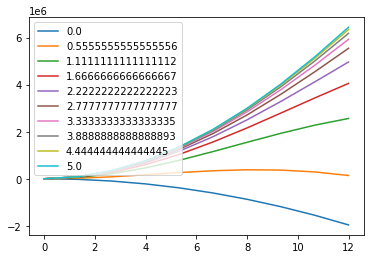

In [10]:
vv = np.linspace(0, 5, 10)
for v in vv:
    s_maker(53,58, 2, 9.13268e9, v, plot=True)
    
plt.legend(vv)

In [11]:
nmin = int(53)
nmax = int(58)
q = 2

vv = np.linspace(0.15, 1, 4)
ff = np.linspace(9.129568e9, 9.135568e9, 4)

calcs = {}

for v in vv:
    print(v)
    fdict = {}
    for f in ff:
        vf =  s_maker(nmin, nmax, q, f, v)
        fdict[f] = vf

    calcs[v] = fdict


0.15


In [ ]:
import json
with open("dump.json","w") as f:
    json.dump(calcs,f)

In [ ]:
xx = np.zeros((4,4))
for i in range(len(vv)):
    for j in range(len(ff)):
        xx[i][j] = calcs[vv[i]][ff[j]]

In [ ]:
xx

array([[0.82758621, 0.82758621, 0.82758621],
       [0.82758621, 0.82758621, 0.82758621],
       [0.82758621, 0.82758621, 0.82758621]])

In [ ]:
np.min(ff)*10**(-9)

9.129568

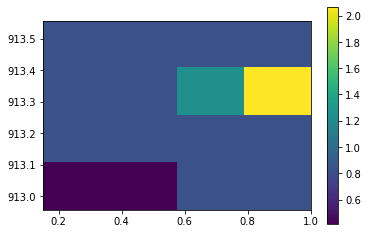

In [ ]:
plt.imshow(xx, extent = [np.min(vv) , np.max(vv), np.min(ff)*10**(-7) , np.max(ff)*10**(-7)])
plt.colorbar()


## Electric Field Strength of Dressing Field Calculation

In [ ]:
qd = QuantumDefects(defects)
debye = 3.33564e-30

qd.calc_matrix_element(55, 0, 56, 0, 100) * e * a_He/debye

0.0

In [ ]:
dd = qd.calc_matrix_element(55, 0, 56, 1, 100) * e * a_He
dd

6.410635060942596e-28

Rabi Frequency:
$$
\Omega_{ij} = \frac{\bf{d_{ij}} \cdot \bf{E_0}}{\hbar}
$$

where $\bf{d_{ij}}$ is the transition dipole moment and $\bf{E_0}$ is the vetor electric field amplitude.

Field strength of AC electric field.

In [ ]:
rabi = 10e6

E = rabi/dd * hbar
E

1.6450348366031302

In [ ]:
s_maker(53,58, 9.12568e9, 2, 0, plot=True)
plt.ylim([-1.5e6, 0])

Error: Session cannot generate requests

# Multi Processing

In [ ]:
import itertools
import numpy as np
import multiprocessing as mp
import time

def calc_mp(indices, data):
    # construct pool
    pool = mp.Pool(mp.cpu_count())

    # we are going to populate the matrix; organize all the inputs; then map them
    matrix = [[0] * len(indices) for i in range(len(indices))]
    args = [(data[i_a], data[i_b]) for i_a, i_b in list(itertools.combinations(indices, 2))]
    results = pool.starmap(algorithm, args)

    # unpack the results into the matrix
    for i_tuple, result in zip([(i_a, i_b) for i_a, i_b in list(itertools.combinations(indices, 2))], results):
        # unpack
        i_a, i_b = i_tuple
        a_res, b_res = result

        # set it in the matrix
        matrix[i_b][i_a] = a_res
        matrix[i_a][i_b] = b_res

    return matrix

def calc_single(indices, data):
    # do the simple single process version
    matrix = [[0] * len(indices) for i in range(len(indices))]
    for i_a, i_b in list(itertools.combinations(indices, 2)):
        a_res, b_res = algorithm(data[i_a], data[i_b])
        matrix[i_b][i_a] = a_res
        matrix[i_a][i_b] = b_res

    return matrix

def algorithm(a,b):
    # Very slow and complex
    time.sleep(2)
    return a + b, a - b

if __name__ == "__main__":
    # generate test data;
    indices = range(5)
    data = range(len(indices))

    # test single
    time_start = time.time()
    print(calc_single(indices, data))
    print("Took {}".format(time.time() - time_start))

    # mp
    time_start = time.time()
    print(calc_mp(indices, data))
    print("Took {}".format(time.time() - time_start))

[[0, -1, -2, -3, -4], [1, 0, -1, -2, -3], [2, 3, 0, -1, -2], [3, 4, 5, 0, -1], [4, 5, 6, 7, 0]]
Took 20.030243158340454


Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.8/3.8.8_1/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python@3.8/3.8.8_1/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python@3.8/3.8.8_1/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/Cellar/python@3.8/3.8.8_1/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'algorithm' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.8/3.8.8_1/Frameworks/Python.framework/Versions/3.8/li